# Setup

In [7]:
import sys
sys.path.append('..')

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import json
import pandas as pd
from data_viz.utils import filter_string, extract_values, get_zipcode_from_geojson, create_amsterdam_heatmap, extract_zip, create_folder
import geopandas as gpd

# Extract data from zips

In [10]:
create_folder(folder_path="../data/bronze")
create_folder(folder_path="../data/silver")
create_folder(folder_path="../outputs")

In [24]:
zip_file_paths = ['../data/geo/amsterdam_areas.zip', '../data/geo/post_codes.zip']
for zip_file_path in zip_file_paths:
    extract_zip(zip_file_path, extract_destination="../data/bronze")
    
zip_file_paths = ['../data/airbnb.zip', '../data/rentals.zip']
for zip_file_path in zip_file_paths:
    extract_zip(zip_file_path, extract_destination="../data/bronze")

Contents extracted to ../data/bronze
Contents extracted to ../data/bronze
Contents extracted to ../data/bronze
Contents extracted to ../data/bronze


# Load Data

In [26]:
# postcodes
geojson_path = '../data/bronze/post_codes.geojson'
amsterdam_postcode_map = gpd.read_file(geojson_path)

# airbnb
airbnb = pd.read_csv("../data/bronze/airbnb.csv")
# filter out missing data (-40% of dataset)
airbnb = airbnb.dropna(axis=0)
# add vars
airbnb["pc4_code"] = airbnb.zipcode.apply(lambda x: filter_string(x))
# airbnb['coordinates'] = list(zip(airbnb['latitude'], airbnb['longitude']))
airbnb["price_per_bedroom"] = airbnb["price"] / airbnb["bedrooms"]
airbnb["price_per_accommodates"] = airbnb["price"] / airbnb["accommodates"]
airbnb.to_parquet("../data/silver/airbnb.parquet")
# extract room types
room_types = airbnb.room_type.unique()
room_types_map = {'Entire home/apt': 'entire_home', 'Private room': 'private_room', 'Shared room': 'shared_room'}

# kamernet
json_file_path = '../data/bronze/rentals.json'
with open(json_file_path, 'r') as file:
    kamernet = json.load(file)
kamernet = pd.DataFrame(kamernet)
# clean vars
kamernet["_id"] = kamernet["_id"].apply(lambda x: x[0])
kamernet["crawledAt"] = kamernet["crawledAt"].apply(lambda x: x[0])
kamernet["detailsCrawledAt"] = kamernet["detailsCrawledAt"].apply(lambda x: x[0])
# filter rows
kamernet = kamernet[kamernet.city=="Amsterdam"]
# clean vars
kamernet["_id"] = kamernet["_id"].apply(lambda x: x[0])
kamernet["crawledAt"] = kamernet["crawledAt"].apply(lambda x: x[0])
kamernet["detailsCrawledAt"] = kamernet["detailsCrawledAt"].apply(lambda x: x[0])
# combine
kamernet['coordinates'] = list(zip(kamernet['latitude'], kamernet['longitude']))
# add price
kamernet["price"] = kamernet["rent"].apply(lambda x: extract_values(x))
# sanity check: zip code matches files
kamernet["pc4_code"] = kamernet["coordinates"].apply(lambda x: get_zipcode_from_geojson(x, amsterdam_postcode_map))
kamernet["postalCode"] = kamernet["postalCode"].apply(lambda x: x[:4])
print(sum(kamernet["postalCode"]==kamernet["pc4_code"])/kamernet.shape[0])
kamernet.to_parquet("../data/silver/kamernet.parquet")

0.9215468248085001


# Airbnb
- The size of the appartment is very important, but there is no variable for area
- The number of bedrooms and number of people that it accomodates are ok-ish proxies

   pc4_code  price
25     1077    188
40     1111    185
16     1071    181
31     1033    171
51     1016    167
24     1017    167
61     1012    165
21     1015    165
44     1086    163
41     1011    158
42     1013    157
5      1026    156
43     1019    150
45     1087    148
49     1083    146
11     1098    143
64     1165    139
3      1018    139
22     1025    138
36     1074    137
   pc4_code  price
66     1012    115
29     1017    103
18     1071     97
56     1016     97
44     1023     95
46     1011     93
24     1015     92
5      1026     85
40     1072     84
26     1044     82
3      1018     82
41     1074     79
6      1081     78
48     1019     77
72     1051     76
1      1108     76
32     1032     75
71     1036     75
22     1034     75
47     1013     74
   pc4_code  price
1      1058     99
7      1017     95
6      1015     85
2      1102     80
12     1016     75
9      1011     65
8      1072     60
4      1103     60
5      1075     60
18     1012 

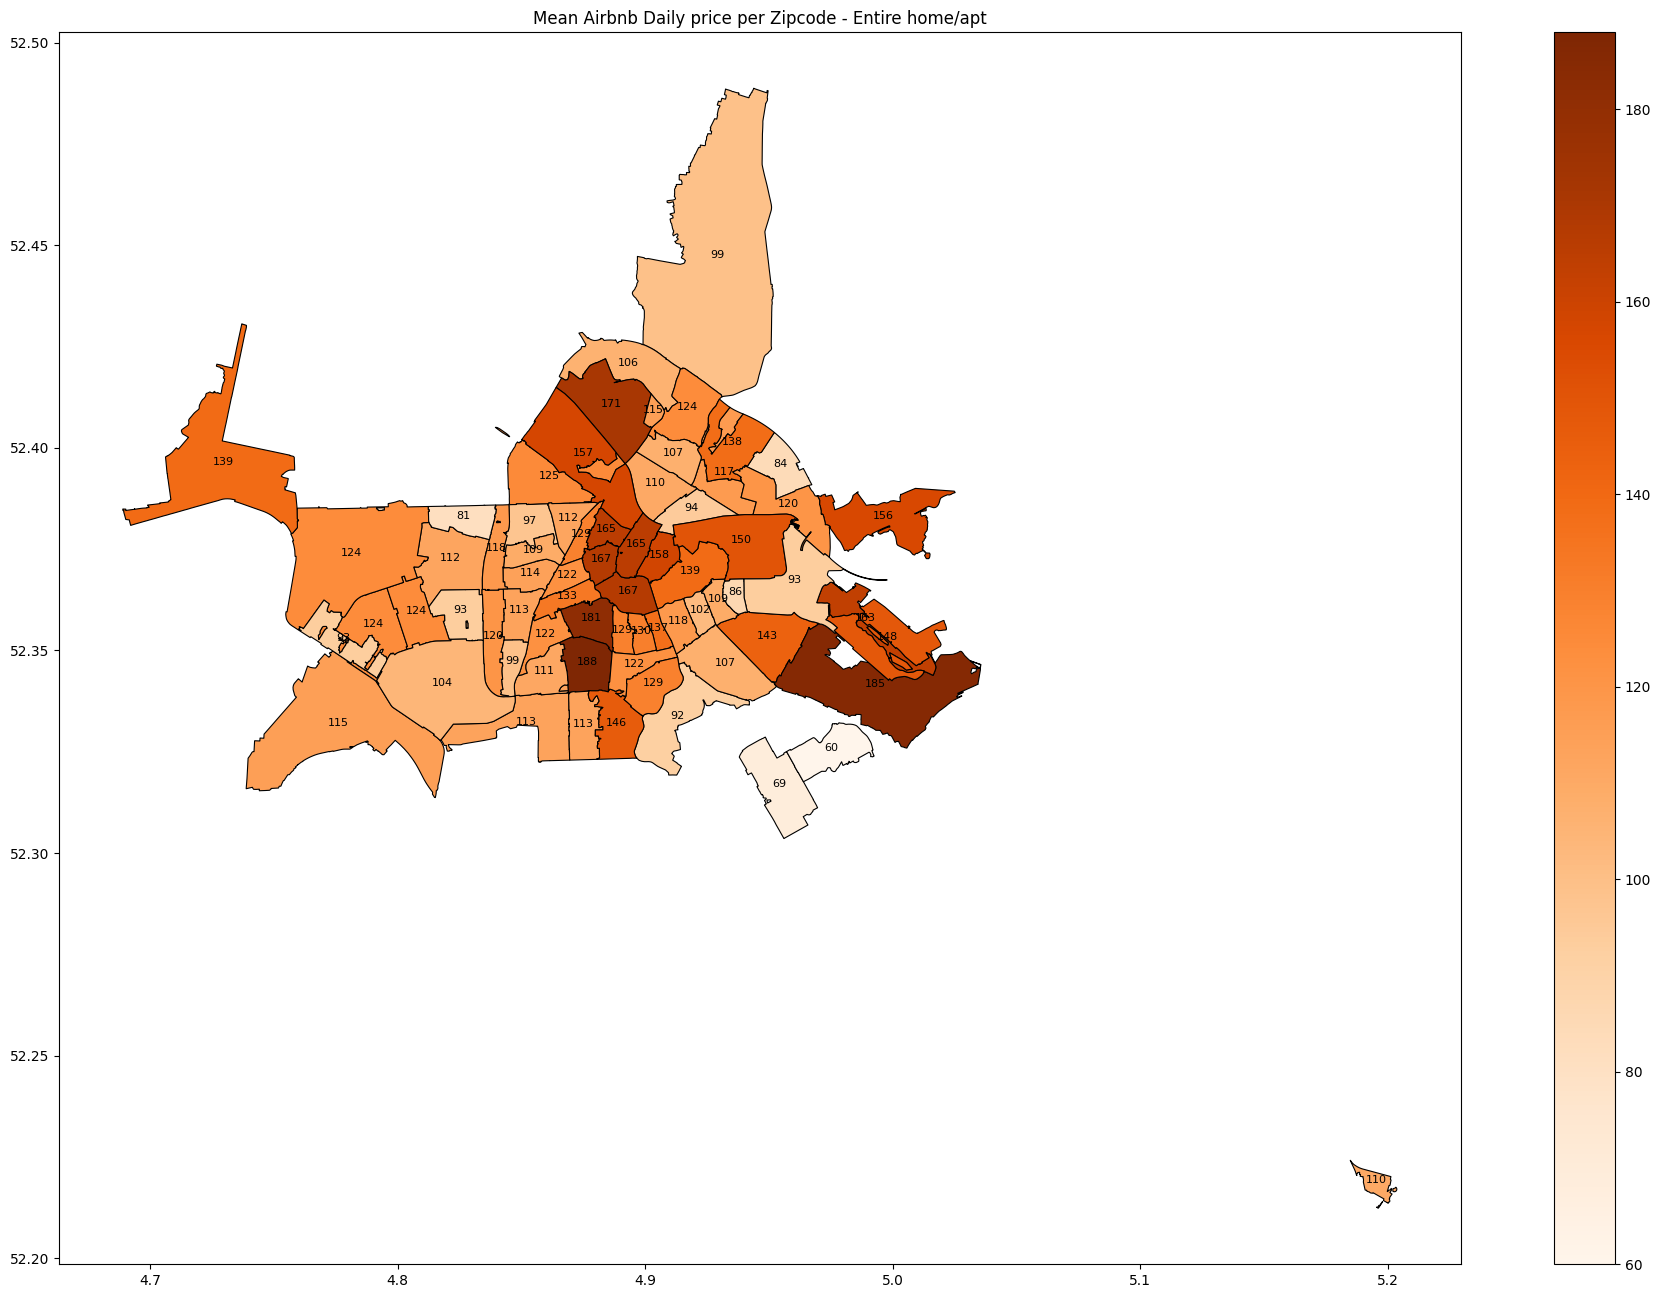

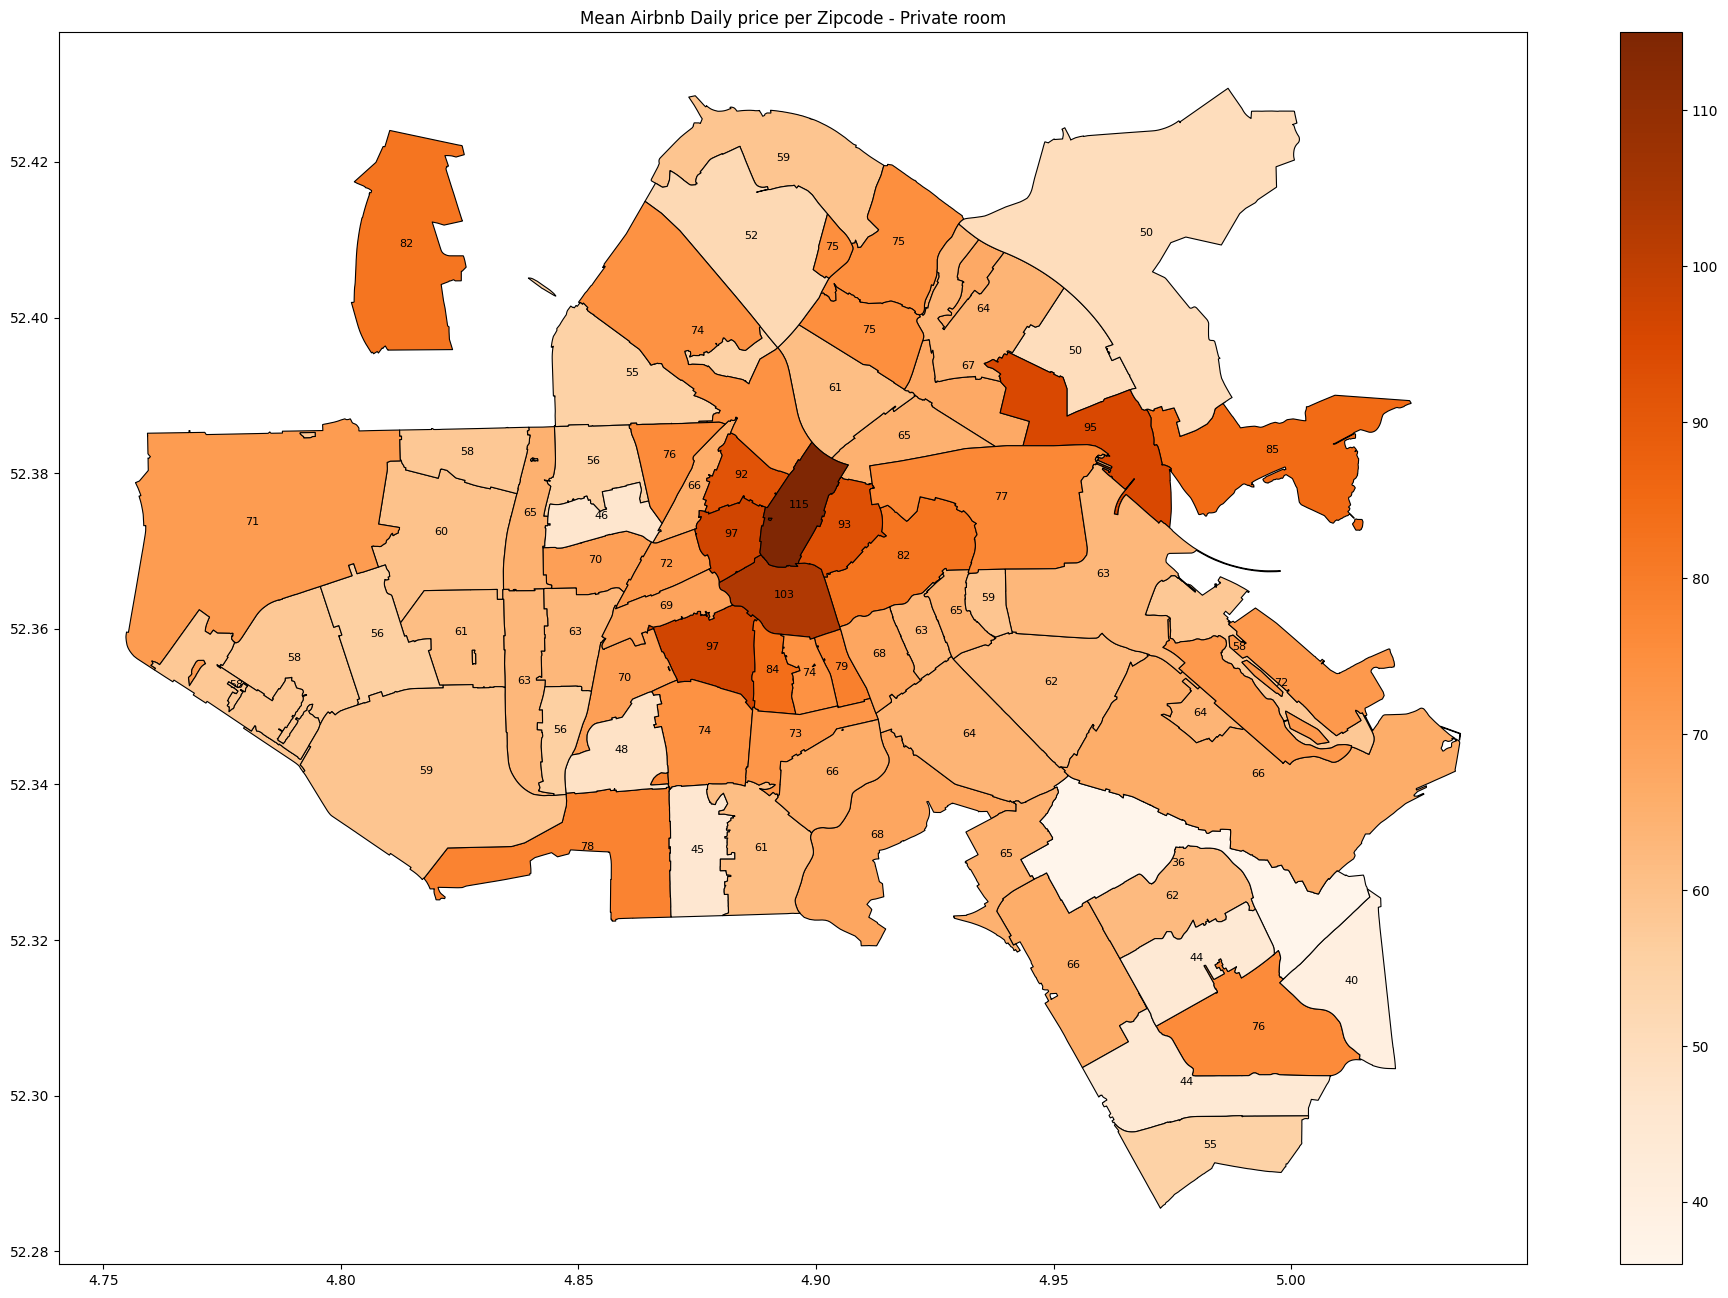

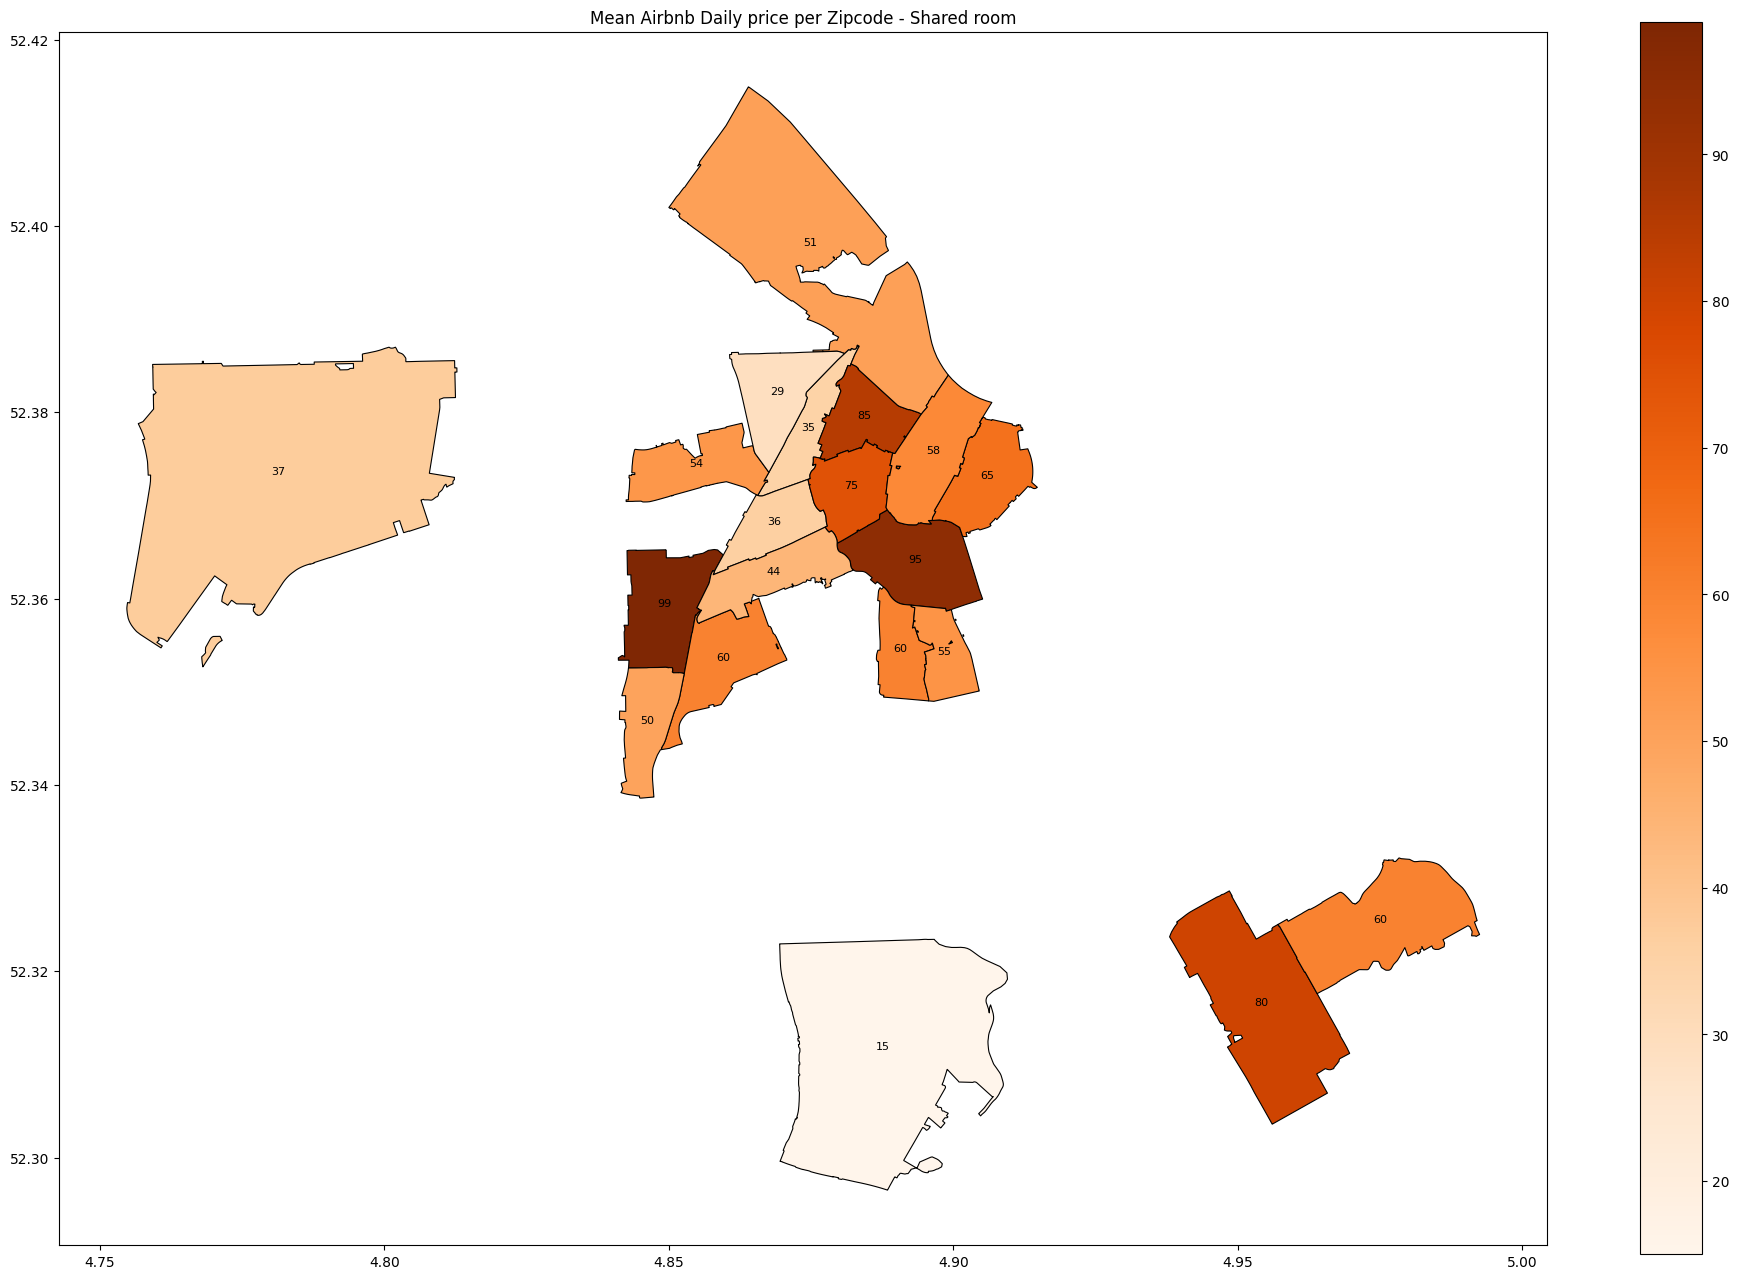

In [34]:
for room_type in room_types:
    target = "price"
    prices = airbnb[airbnb.room_type==room_type].groupby('pc4_code')[target].mean().reset_index() # change here
    amsterdam_map = pd.merge(amsterdam_postcode_map, prices, on='pc4_code', how='inner')
    amsterdam_map[target] = amsterdam_map[target].apply(lambda x: int(round(x)))
    title = f'Mean Airbnb Daily {target} per Zipcode - {room_type}'
    fig = create_amsterdam_heatmap(amsterdam_map, target, title)
    fig.savefig(f"../outputs/airbnbairbnb-{room_types_map[room_type]}-mean.png")
    outputs = amsterdam_map[["pc4_code", "price"]].sort_values(["price"], ascending=False)
    print(outputs.head(20))
    outputs.to_parquet(f"../outputs/airbnb-{room_types_map[room_type]}-mean.parquet")
    
# 
# for room_type in room_types:
#     target = "price_per_bedroom"
#     prices = airbnb[(airbnb.room_type==room_type)&(airbnb.bedrooms>0)].groupby('pc4_code')[target].mean().reset_index() # change here
#     amsterdam_map = pd.merge(amsterdam_postcode_map, prices, on='pc4_code', how='inner')
#     amsterdam_map[target] = amsterdam_map[target].apply(lambda x: int(round(x)))
#     title = f'Mean Airbnb Daily {target} per Zipcode - {room_type}'
#     create_amsterdam_heatmap(amsterdam_map, target, title)
#     
# for room_type in room_types:
#     target = "price_per_accommodates"
#     prices = airbnb[(airbnb.room_type==room_type)&(airbnb.accommodates>0)].groupby('pc4_code')[target].mean().reset_index() # change here
#     amsterdam_map = pd.merge(amsterdam_postcode_map, prices, on='pc4_code', how='inner')
#     amsterdam_map[target] = amsterdam_map[target].apply(lambda x: int(round(x)))
#     title = f'Mean Airbnb Daily {target} per Zipcode - {room_type}'
#     create_amsterdam_heatmap(amsterdam_map, target, title)

# Kamernet
- Meand and median looks very similar
- Outlier values draw attention -> need further investigation

   pc4_code  price
50     1028   2595
57     1054   1500
2      1014   1361
30     1017   1353
42     1074   1337
56     1016   1319
66     1012   1293
46     1011   1269
58     1059   1269
25     1015   1220
41     1072   1171
48     1019   1171
0      1052   1169
20     1071   1149
45     1023   1147
47     1013   1138
5      1018   1125
10     1022   1101
22     1075   1076
59     1073   1076


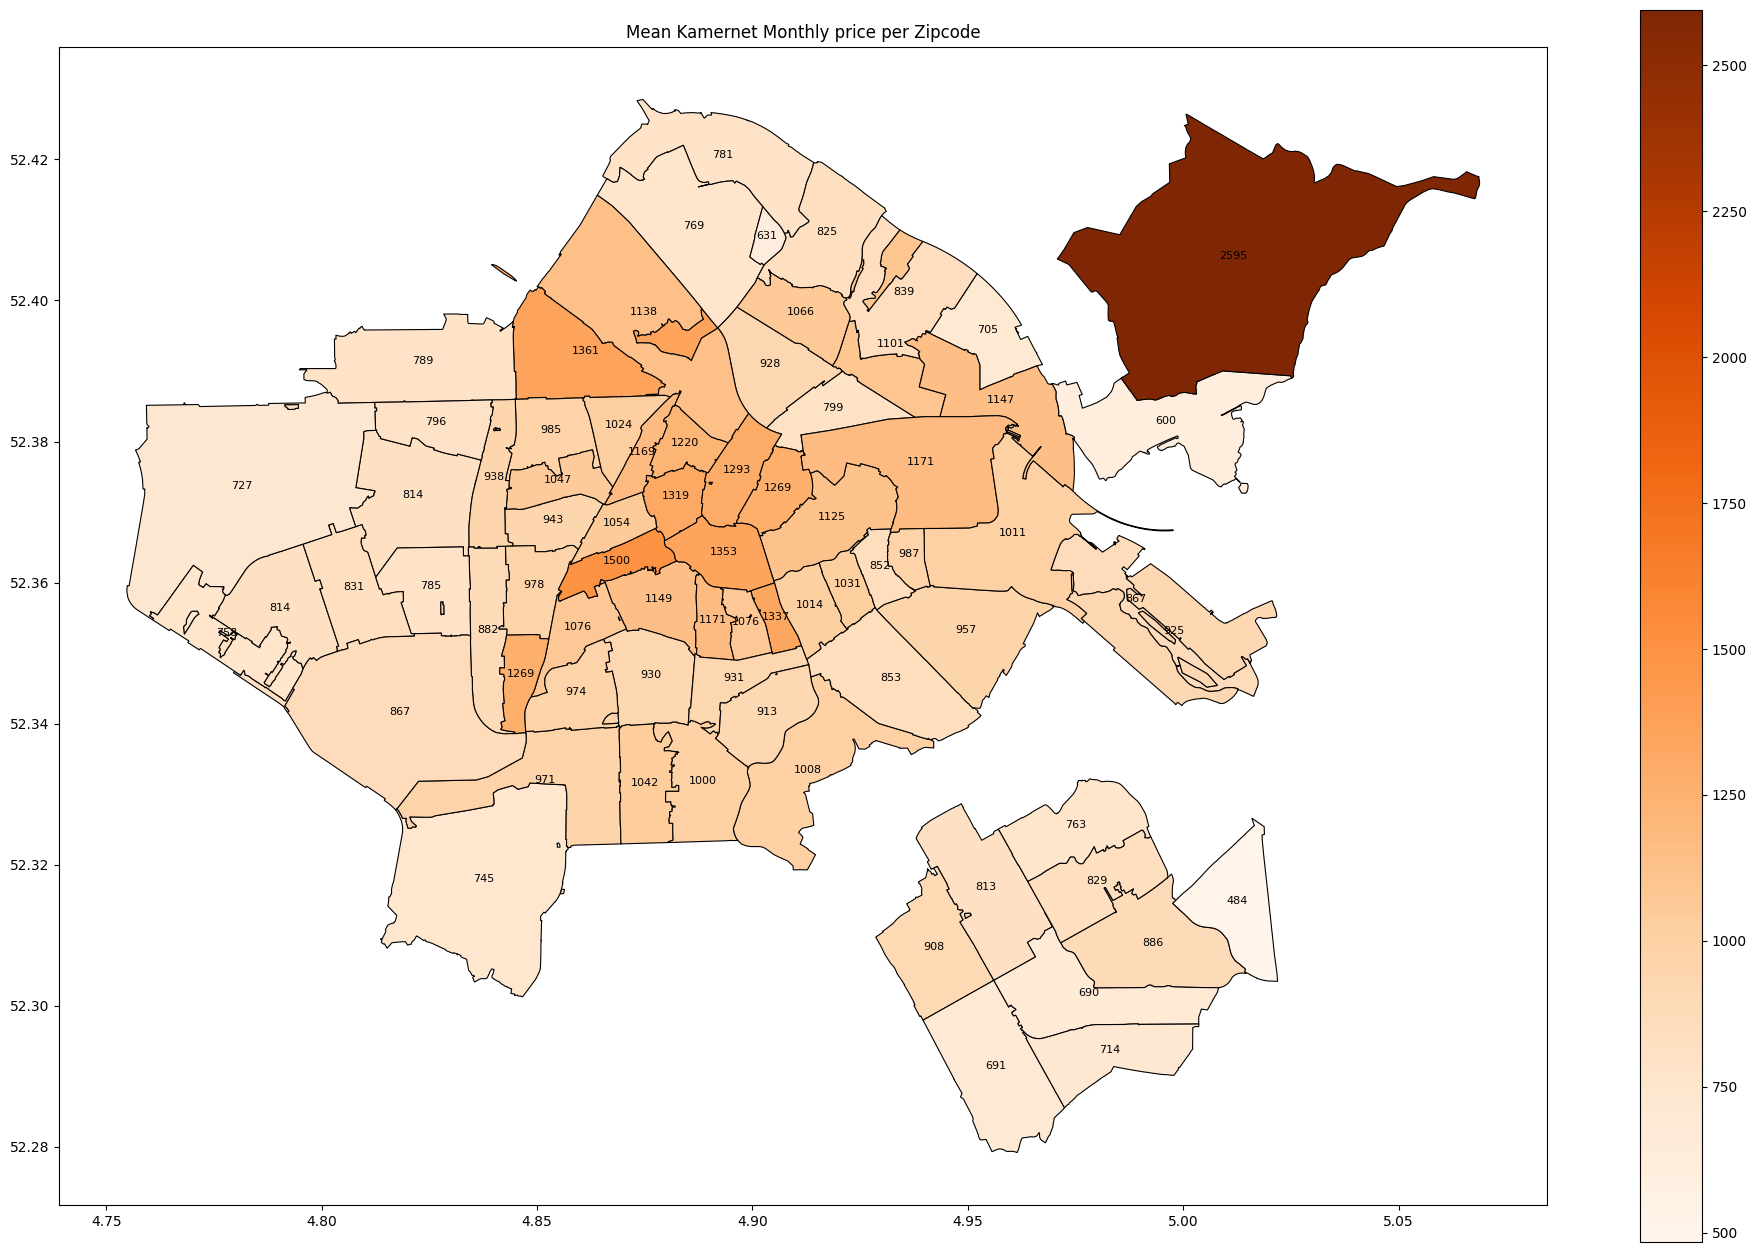

In [36]:
target = "price"
prices = kamernet.groupby('pc4_code')[target].mean().reset_index() # change here
amsterdam_map = pd.merge(amsterdam_postcode_map, prices, on='pc4_code', how='inner')
amsterdam_map[target] = amsterdam_map[target].apply(lambda x: int(round(x)))
title = f'Mean Kamernet Monthly {target} per Zipcode'
fig = create_amsterdam_heatmap(amsterdam_map, target, title)
fig.savefig(f"../outputs/kamernet-mean.png")
outputs = amsterdam_map[["pc4_code", "price"]].sort_values(["price"], ascending=False)
print(outputs.head(20))
outputs.to_parquet(f"../outputs/kamernet-mean.parquet")